# **Homework 3 - Convolutional Neural Network**

# **Result**
scores (pass medium baseline):

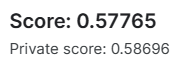

medium baseline:

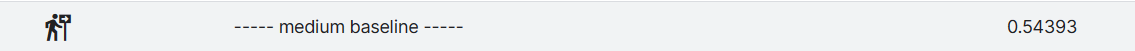

# **Download Data**

In [ ]:
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip
!unzip -q food-11.zip

# **Import Some Packages**

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder

from tqdm.auto import tqdm

In [3]:
train_tfm = transforms.Compose([

    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    #transforms.Normalize(
    #  mean=[0.485, 0.456, 0.406],
		#  std=[0.229, 0.224, 0.225]
    #),
])

test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# **Dataset and DataLoader**

In [4]:
batch_size = 128

train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# **Create Model**

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            #nn.Dropout(0.2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(0.2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(0.2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 8 * 8, 256),
            #nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 256),
            #nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

        self.criterion = nn.CrossEntropyLoss()

        #self.model = torchvision.models.resnet18(pretrained=False)

    def forward(self, x):
        #x = self.cnn_layers(x)

        x = self.cnn_layers(x)

        x = x.flatten(1)

        x = self.fc_layers(x)
        return x

    def cal_loss(self, pred, target):

      l2 = 0
      for i in self.parameters():
        l2 += torch.sum(torch.pow(i, 2))

      loss = self.criterion(pred, target)

      return loss + 0.01 * l2, loss

In [6]:
class PseudoDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

def get_pseudo_labels(dataset, model, threshold=0.65):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()

    softmax = nn.Softmax(dim=-1)

    images = []
    labels = []

    for batch in tqdm(data_loader):
        img, _ = batch

        with torch.no_grad():
            logits = model(img.to(device))

        probs = softmax(logits)

        for i, prob in enumerate(probs):
          if prob > threshold:
            images.append(img[i])
            labels.append(int(torch.argmax(prob)))

    dataset = PseudoDataset(images, labels)
    model.train()
    return dataset

# **Training**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Classifier().to(device)
model.device = device

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

n_epochs = 100

do_semi = False

for epoch in range(n_epochs):

    if epoch == 0:
      optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
    if epoch == 50:
      optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

    if do_semi and epoch > 25 and epoch % 5 == 0:
        pseudo_set = get_pseudo_labels(unlabeled_set, model)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        imgs, labels = batch

        logits = model(imgs.to(device))

        l2_loss, loss = model.cal_loss(logits, labels.to(device))

        optimizer.zero_grad()


        l2_loss.backward()

        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    model.eval()


    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):


        imgs, labels = batch

        with torch.no_grad():
          logits = model(imgs.to(device))

        _, loss = model.cal_loss(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

# **Testing**

In [ ]:
model.eval()
predictions = []

for batch in tqdm(test_loader):
    imgs, labels = batch

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [9]:
with open("predict.csv", "w") as f:

    f.write("Id,Category\n")

    for i, pred in enumerate(predictions):
         f.write(f"{i},{pred}\n")